In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [2]:
input_path = "../content/DATA_CHAMBER_2021/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"

In [5]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # called by dataloaders
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
preprocess = {
    'train':
    transforms.Compose([
        transforms.Resize(229),
        transforms.CenterCrop(229),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(229),
        transforms.CenterCrop(229),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', preprocess['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', preprocess['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True)
}

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_1', pretrained=False)
model.classifier[1] = nn.Conv2d(512, 3, kernel_size=(1,1), stride=(1,1))
# fine tuning

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [8]:
import torchvision
from torch.autograd import Variable
import time
from PIL import Image
from torchvision import transforms

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [10]:
# t0 = time.time()
# print('{} seconds'.format(time.time() - t0)
epochLine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [11]:
def train_model(model, criterion, optimizer, num_epochs=1):
    train_batches = len(dataloaders['train'])
    lossLine = []
    accLine = []
    timeLine = []
    for epoch in range(num_epochs):
        print('-' * 40)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)
        t0 = time.time()

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            training_loss = 0.0
            training_corrects = 0

            for i,data in enumerate(dataloaders[phase]):
                inputs, labels,_ = data
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # loss.requires_grad = True

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                training_loss += loss.item() * inputs.size(0)
                training_corrects += torch.sum(preds == labels.data)

            epoch_loss = training_loss / len(image_datasets[phase])
            lossLine.append(epoch_loss)
            epoch_acc = training_corrects.double() / len(image_datasets[phase])
            accLine.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            t1 = time.time()
            t = t1 - t0
            print('Duration :{} seconds'.format(t))
            ts = pd.DataFrame([t]).apply(np.float32)
            timeLine.append(ts)
    return model, lossLine, accLine, timeLine

In [12]:
model = model.to(device)
model_trained, lossLine, accLine, timeLine = train_model(model, criterion, optimizer, num_epochs=20)

----------------------------------------
Epoch 1/20
--------------------
Training batch 210/210train loss: 1.0978, acc: 0.3563
Duration :62.35540747642517 seconds
----------------------------------------
Epoch 2/20
--------------------
Training batch 210/210train loss: 1.0930, acc: 0.3655
Duration :60.08956527709961 seconds
----------------------------------------
Epoch 3/20
--------------------
Training batch 210/210train loss: 1.0765, acc: 0.4018
Duration :60.04800891876221 seconds
----------------------------------------
Epoch 4/20
--------------------
Training batch 210/210train loss: 1.0160, acc: 0.4730
Duration :58.9672908782959 seconds
----------------------------------------
Epoch 5/20
--------------------
Training batch 210/210train loss: 0.8347, acc: 0.6245
Duration :59.78667068481445 seconds
----------------------------------------
Epoch 6/20
--------------------
Training batch 210/210train loss: 0.6959, acc: 0.7022
Duration :59.976394176483154 seconds
----------------------

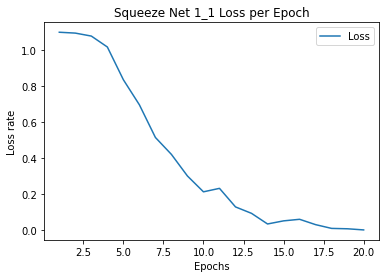

In [13]:
plt.plot(epochLine, lossLine, label="Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss rate")
plt.title("Squeeze Net 1_1 Loss per Epoch")
plt.legend()
plt.show()

In [14]:
print(lossLine)

[1.0977571119026217, 1.0930049645327484, 1.0765468512721514, 1.016026627392717, 0.8347416537866114, 0.6958848567560562, 0.5149765838127823, 0.4211597408640681, 0.301643376444819, 0.2139644465788154, 0.23319310028185283, 0.13038307537839264, 0.09473255353714803, 0.035888704297837, 0.053109308766988404, 0.06179919992337159, 0.0321860358929204, 0.011380249772863362, 0.009254703111031482, 0.00299107660807999]


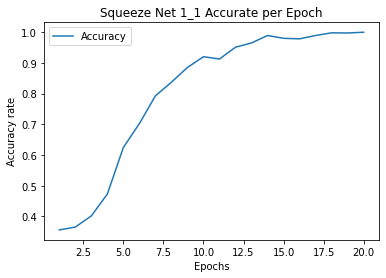

In [15]:
plt.plot(epochLine, accLine, label="Accuracy")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy rate")
plt.title("Squeeze Net 1_1 Accurate per Epoch")
plt.legend()
plt.show()

In [16]:
print(accLine)

[tensor(0.3563, device='cuda:0', dtype=torch.float64), tensor(0.3655, device='cuda:0', dtype=torch.float64), tensor(0.4018, device='cuda:0', dtype=torch.float64), tensor(0.4730, device='cuda:0', dtype=torch.float64), tensor(0.6245, device='cuda:0', dtype=torch.float64), tensor(0.7022, device='cuda:0', dtype=torch.float64), tensor(0.7925, device='cuda:0', dtype=torch.float64), tensor(0.8368, device='cuda:0', dtype=torch.float64), tensor(0.8849, device='cuda:0', dtype=torch.float64), tensor(0.9198, device='cuda:0', dtype=torch.float64), tensor(0.9123, device='cuda:0', dtype=torch.float64), tensor(0.9507, device='cuda:0', dtype=torch.float64), tensor(0.9646, device='cuda:0', dtype=torch.float64), tensor(0.9888, device='cuda:0', dtype=torch.float64), tensor(0.9796, device='cuda:0', dtype=torch.float64), tensor(0.9780, device='cuda:0', dtype=torch.float64), tensor(0.9888, device='cuda:0', dtype=torch.float64), tensor(0.9975, device='cuda:0', dtype=torch.float64), tensor(0.9970, device='cuda

In [17]:
total_time_train = 0
for i in timeLine:  total_time_train += i
print(total_time_train)

             0
0  1195.000977


In [18]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(classification_report(y_true,y_pred))
accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       409
           1       0.63      0.88      0.73       367
           2       1.00      0.79      0.88       831

    accuracy                           0.81      1607
   macro avg       0.79      0.82      0.80      1607
weighted avg       0.85      0.81      0.82      1607



0.8139390168014935

In [20]:
df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),
               columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [21]:
vid_list = list(set(df['vid_id'].values))

y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

vid: 193 label: 2 pred: 2
vid: 167 label: 2 pred: 2
vid: 161 label: 1 pred: 1
vid: 175 label: 1 pred: 1
vid: 174 label: 1 pred: 0
vid: 171 label: 0 pred: 0
vid: 179 label: 1 pred: 0
vid: 172 label: 2 pred: 2
vid: 187 label: 2 pred: 2
vid: 188 label: 2 pred: 0
vid: 182 label: 2 pred: 2
vid: 186 label: 1 pred: 1
vid: 164 label: 2 pred: 2
vid: 163 label: 2 pred: 2
vid: 173 label: 2 pred: 2
vid: 169 label: 0 pred: 0
vid: 159 label: 1 pred: 1
vid: 183 label: 0 pred: 1
vid: 184 label: 2 pred: 2
vid: 189 label: 1 pred: 1
vid: 185 label: 1 pred: 0
vid: 178 label: 0 pred: 0
vid: 157 label: 1 pred: 1
vid: 194 label: 1 pred: 1
vid: 176 label: 0 pred: 0
vid: 160 label: 2 pred: 1
vid: 191 label: 0 pred: 0
vid: 158 label: 0 pred: 0
vid: 180 label: 2 pred: 2
vid: 177 label: 0 pred: 0
vid: 166 label: 1 pred: 1
vid: 181 label: 0 pred: 1
vid: 192 label: 0 pred: 0
vid: 162 label: 1 pred: 1
vid: 168 label: 0 pred: 0
vid: 195 label: 2 pred: 2
vid: 170 label: 2 pred: 2
vid: 165 label: 0 pred: 0
vid: 190 lab

In [24]:
accuracy_score(y_true,y_pred)

0.8205128205128205